# Libs

In [262]:
import math
import warnings

import numpy as np
import arviz as az
import pymc3 as pm
import pandas as pd
import seaborn as sns
import scipy.special as sc
import theano.tensor as tt
import matplotlib.pyplot as plt
from scipy import stats
#from theano import shared, function
#from pymc3.distributions.dist_math import betaln, bound

from custom import pert

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

Running on PyMC v3.11.4
Running on ArviZ v0.11.2


# Main

## Passenger Car

In [4]:
car_milage = 2400000 # avg passenger car milage (km)
car_weight = 1000 # avg passenger car weight in (kg)

car_maint = 1080 # GHG per car caused by maintenance (kg)
car_maint_ghg = car_maint / car_milage # GHG per every km caused by maintenance (kg/km)

car_prod = 7 # GHG per kg of car weight caused by production (kg/kg)
car_prod_ghg = car_prod * car_weight / car_milage # GHG per every km caused by production (kg/km)

car_prod_maint_ghg = car_maint_ghg + car_prod_ghg


## Pure Players

### Model

In [4]:
with pm.Model():    
    pp_product_volume = pm.Lognormal(name='Product Weight', mu=-1.38, sigma=1.14) # volume of product in liters (l)
    pp_box_saturation = pert(name='Box Saturation', a=.1, b=.5, c=.9, transform=None) # share of box volume consumed by product (l/l)
    pp_waste_ghg = pm.Bernoulli(name='Waste GHG', p=.21) * 0.15 # GHG of cardboard disposal (either 0 or 0.15)
    
    pp_cardboard_weight = 12.5 # grams of cardboard per every liter of box volume (g/l)
    pp_cardboard_used = pm.Deterministic(name='PP Cardboard Used', var=pp_cardboard_weight * pp_product_volume / pp_box_saturation) # distribution of weights of cardbord per single package (g)

    pp_cardboard_ghg = .001 # kg GHG per g of cardboard (kg/g)
    pp_cardboard_total_ghg = pm.Deterministic(name='PP Cardboard GHG', var=pp_cardboard_used * (pp_cardboard_ghg + pp_waste_ghg))

    pp_paper_weight = .033 # grams of paper per every liter of void volume (g/l)
    pp_paper_used = pm.Deterministic(name='PP Paper Used', var=pp_paper_weight * pp_product_volume * (1 - pp_box_saturation))
    
    pp_paper_ghg = .0012 # kg GHG per g of paper (kg/g)
    pp_paper_total_ghg = pm.Deterministic(name='PP Paper GHG', var=pp_paper_used * (pp_paper_ghg + pp_waste_ghg))
    
    pp_package_total_ghg = pm.Deterministic(name='PP Package GHG', var=pp_cardboard_total_ghg+pp_paper_total_ghg)
    
    
    pp_stem_mileage = pm.Lognormal(name='PP Stem Mileage', mu=2.88, sigma=.76) * 2 # stem mileage (km)
    pp_drop_mileage = pert(name='PP Drop Mileage', a=3.6, b=40, c=96, transform=None) # drop mileage (km)
    pp_lm_distance = pm.Deterministic(name='PP LM Distance', var=pp_stem_mileage + pp_drop_mileage) # total last-mile distance (km)
    pp_deliveries = pert(name='PP Deliveries per Tour', a=32, b=100, c=168, transform=None) # number of completed deliveries per tour
    pp_drop_distance = pm.Deterministic(name='PP Distance per Drop', var=pp_lm_distance / pp_deliveries) # distance travelled per item drop (km)
    
    pp_cargobike_bike_ghg = .05 # GHG emission intensity of cargobike itself (kg/km)
    pp_cargobike_battery_ghg = .01 # GHG emission intensity of cargobike battery (kg/km)
    pp_cargobike_electricity_CN_ghg = .02 * 1.19 # GHG emission intensity of electricity comnsumption in Chine (kg/km)
    pp_cargobike_electricity_NL_ghg = .02 * .62 # Netherlands
    pp_cargobike_electricity_UK_ghg = .02 * .83 # UK
    pp_cargobike_electricity_US_ghg = .02 * .7 # US
    
    pp_cargobike_total_ghg = pp_cargobike_bike_ghg + pp_cargobike_battery_ghg + pp_cargobike_electricity_CN_ghg # average cargobike GHG per km (kg/km)
    pp_van_ghg = pm.Lognormal(name='PP Van GHG', mu=-1.36, sigma=.23) # delivery van GHG per km (kg/km)
    pp_car_ghg = .13 + car_prod_maint_ghg # average car GHG per km (kg/km)
    
    pp_drop_ghg = pm.Deterministic(name='PP Van GHG per Drop', var=pp_van_ghg * pp_drop_distance) # GHG per item drop using a van (kg)
    pp_drop_cargobike_ghg = pm.Deterministic(name='PP Cargobike GHG per Drop', var=pp_van_ghg * pp_stem_mileage / pp_deliveries + pp_cargobike_total_ghg * pp_drop_mileage / pp_deliveries) # GHG per item drop using a van and a cargobike (kg)
    
    pp_failed = pm.Bernoulli(name='PP Failed Delivery', p=.14)
    pp_redelivered = pm.Bernoulli(name='PP Redelivery of Failed', p=.5)
    pp_distance_cdp = pert(name='PP Distance to CDP', a=2, b=4, c=10, transform=None) # ditance to collection & delivery point (km)

    pp_total_drop_ghg = pm.Deterministic(name='PP Total GHG per Drop (van)',
                                         var = pp_drop_ghg
                                         + pp_failed * pp_redelivered * pp_drop_ghg
                                         + pp_failed * tt.switch(tt.eq(pp_redelivered, 1), 0, 1) * tt.switch(tt.gt(pp_distance_cdp, 4), 1, 0) * pp_distance_cdp * pp_car_ghg)
    pp_total_drop_cargobike_ghg = pm.Deterministic(name='PP Total GHG per Drop (cargobike)',
                                                   var=pp_drop_cargobike_ghg
                                                   + pp_failed * pp_redelivered * pp_drop_cargobike_ghg
                                                   + pp_failed * tt.switch(tt.eq(pp_redelivered, 1), 0, 1) * tt.switch(tt.gt(pp_distance_cdp, 4), 1, 0) * pp_distance_cdp * pp_car_ghg)
    
    
    pp_basket = pert(name='PP Basket Size', a=1, b=2, c=5, transform=None) # basket size distribution for pure players

    pp_total_item_ghg = pm.Deterministic(name='PP Total GHG per Item (van)', var=(pp_package_total_ghg + pp_total_drop_ghg) / pp_basket)
    pp_total_cargobike_item_ghg = pm.Deterministic(name='PP Total GHG per Item (cargobike)', var=(pp_package_total_ghg + pp_total_drop_cargobike_ghg) / pp_basket)
    
    data = pm.sample(100000, tune=10000)
    

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [PP Basket Size, PP Distance to CDP, PP Van GHG, PP Deliveries per Tour, PP Drop Mileage, PP Stem Mileage, Box Saturation, Product Weight]
>BinaryGibbsMetropolis: [Waste GHG, PP Failed Delivery, PP Redelivery of Failed]


/Applications/anaconda3/envs/pymcenv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 10_000 tune and 100_000 draw iterations (40_000 + 400_000 draws total) took 151 seconds.
There were 90702 divergences after tuning. Increase `target_accept` or reparameterize.
There were 90614 divergences after tuning. Increase `target_accept` or reparameterize.
There were 85610 divergences after tuning. Increase `target_accept` or reparameterize.
There were 94716 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


## Bricks & Clicks

### Model

### Sampling

In [5]:
#az.plot_trace(data);

In [6]:
#az.plot_posterior(data);

<AxesSubplot:title={'center':'x'}>

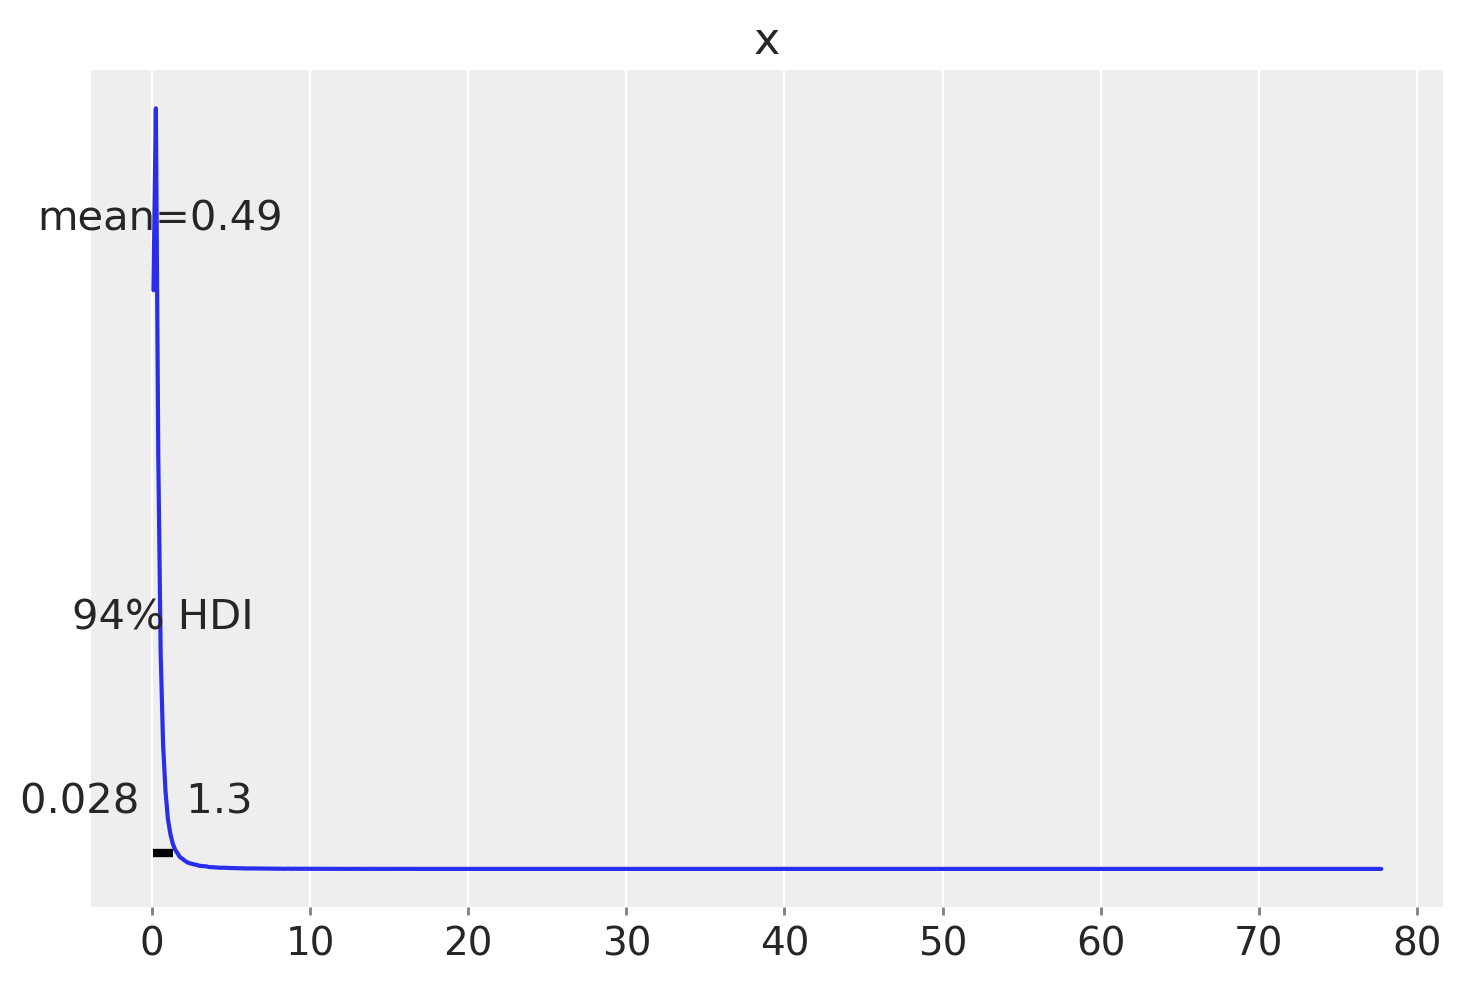

In [7]:
az.plot_posterior(data['PP Total GHG per Item (van)'])

In [8]:
sr = pd.Series(data['PP Total GHG per Item (van)'])
sr.describe()

count    400000.000000
mean          0.492340
std           0.942500
min           0.012630
25%           0.168585
50%           0.282221
75%           0.500414
max          77.830456
dtype: float64

In [9]:
sr.quantile(q=.95)

1.4519891604944297

<AxesSubplot:ylabel='Count'>

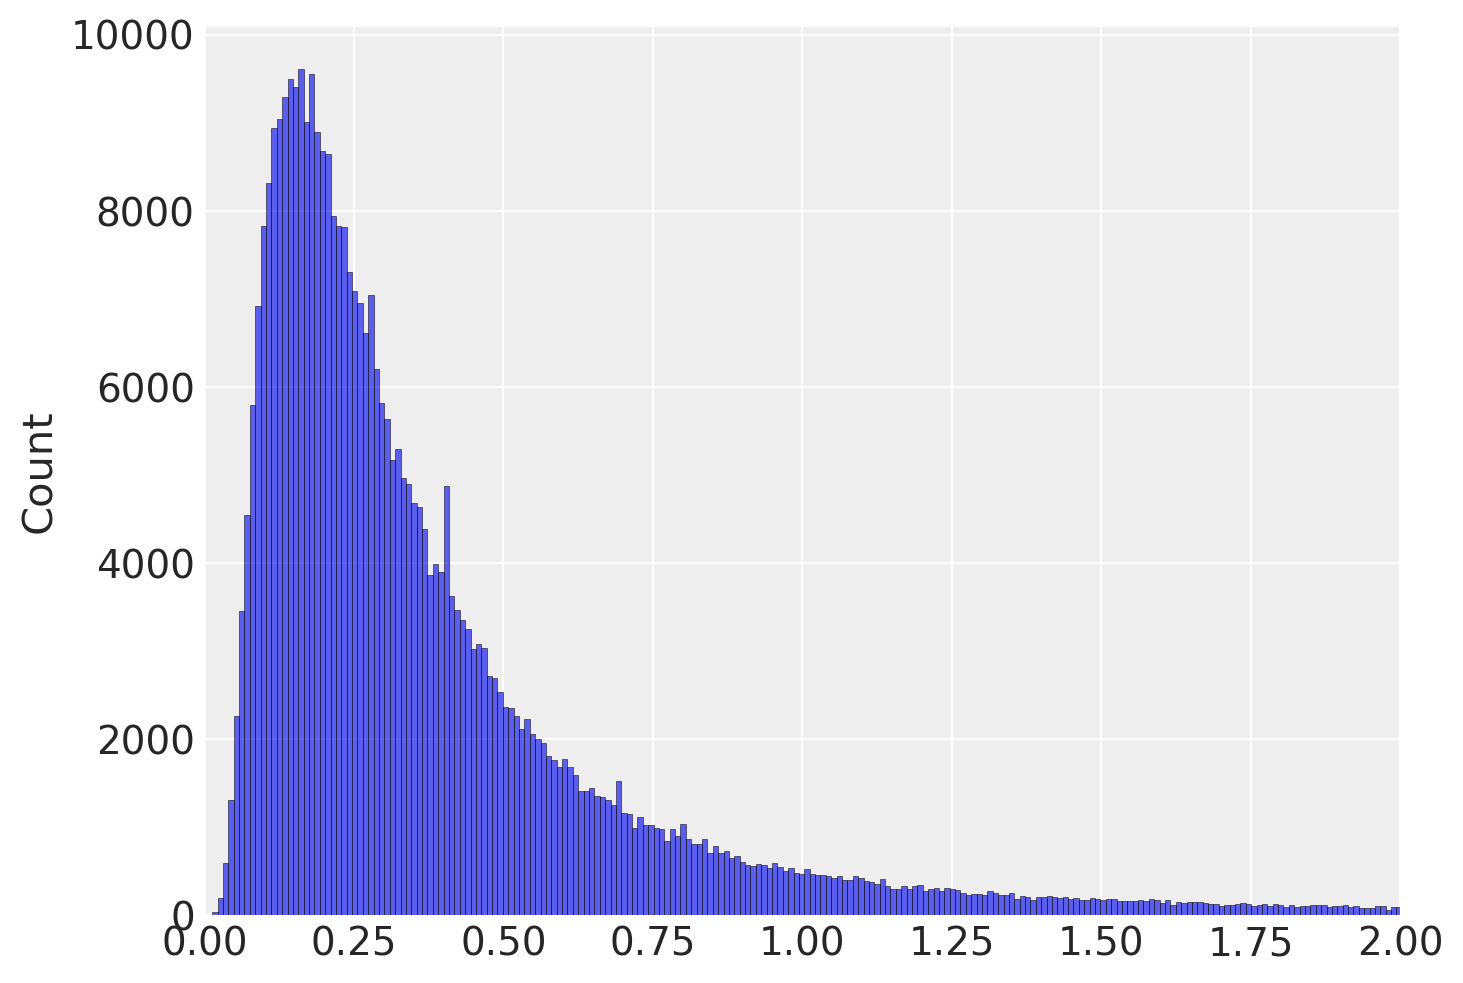

In [10]:
fig, ax = plt.subplots()
ax.set_xlim(0, 2)
#ax.set_ylim(0, 100)
sns.histplot(data['PP Total GHG per Item (van)'])

## Bricks & Clicks

### Model

In [5]:
with pm.Model():
    bc_distance = pert(name='BC Delivery Distance', a=2.1, b=4.3, c=7.3, transform=None) # distance travelled per delivery (km)
    bc_van_ghg = pm.Lognormal(name='BC Van GHG', mu=-1.36, sigma=.23) # delivery van GHG per km (kg/km)
    bc_drop_ghg = pm.Deterministic(name='BC GHG per Drop', var=bc_distance * bc_van_ghg)
    
    bc_basket = pert(name='BC Basket Size', a=5, b=45, c=100, transform=None) # basket size distribution for bricks & clicks

    bc_total_item_ghg = pm.Deterministic(name='PP Total GHG per Item', var=bc_drop_ghg / bc_basket)
    
    data = pm.sample(100000, tune=10000)


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'BC Delivery Distance': array(4.43333333), 'BC Van GHG_log__': array(-1.36), 'BC Basket Size': array(47.5)}

Initial evaluation results:
BC Delivery Distance   -1.02
BC Van GHG_log__        0.55
BC Basket Size          -inf
Name: Log-probability of test_point, dtype: float64

## Bricks & Mortar

### Model

In [9]:
with pm.Model():

    ########## UK ##########
    
    bm_mode_uk = pm.Categorical(name='BM Mode of Transport (UK)', p=[.09, .8, .1, .01]) # mode of trasport (walk=0.09, car=0.8, bus=0.1, bike=0.01)
    
    bm_walk_distance_uk = pm.Lognormal(name='BM Walk Distance (UK)', mu=-.28, sigma=.62) * 1.609344 # converted from miles to kilometers (km)
    bm_car_distance_uk = pm.Lognormal(name='BM Car Distance (UK)', mu=1.11, sigma=1.01) * 1.609344 # (km)
    bm_bus_distance_uk = pm.Lognormal(name='BM Bus Distance (UK)', mu=1.06, sigma=.82) * 1.609344 # (km)
    bm_bike_distance_uk = pm.Lognormal(name='BM Bike Distance (UK)', mu=1.16, sigma=2.19) * 1.609344 # (km)

    bm_walk_ghg_uk = 0
    bm_car_emission_uk = pm.Lognormal(name='BM Car Emission (UK)', mu=-2.08, sigma=.2) # emission intensity of a passenfer car (kg/km)
    bm_car_ghg_uk = pm.Deterministic(name='BM Car GHG (UK)', var=bm_car_emission_uk + car_prod_maint_ghg) # passenger car GHG including production and maintenance ()
    bm_bus_ghg_uk = pm.Lognormal(name='BM Bus GHG (UK)', mu=-2.27, sigma=.28) # (kg/km)
    bm_bike_ghg_uk = 0
    
    bm_walk_trip_ghg_uk = pm.Deterministic(name='BM Walk Trip GHG (UK)', var=bm_walk_distance_uk*2*bm_walk_ghg_uk)
    # NOT FINISHED
    bm_car_trip_ghg_uk = pm.Deterministic(name='BM Car Trip GHG (UK)', var=bm_car_distance_uk*2*bm_car_ghg_uk)
    # ??? Trip_Allocation
    bm_bus_trip_ghg_uk = pm.Deterministic(name='BM Bus Trip GHG (UK)', var=bm_bus_distance_uk*2*bm_bus_ghg_uk)
    bm_bike_trip_ghg_uk = pm.Deterministic(name='BM Bike Trip GHG (UK)', var=bm_bike_distance_uk*2*bm_bike_ghg_uk)
    
    bm_walk_basket_uk = pert(name='BM Walk Basket Size (UK)', a=1, b=5, c=15, transform=None)
    bm_car_basket_uk = pert(name='BM Car Basket Size (UK)', a=1, b=30, c=70, transform=None)
    bm_bus_basket_uk = pert(name='BM Bus Basket Size (UK)', a=1, b=10, c=20, transform=None)
    bm_bike_basket_uk = pert(name='BM Bike Basket Size (UK)', a=1, b=5, c=15, transform=None)    
    
    bm_walk_item_ghg_uk = pm.Deterministic(name='BM Walk GHG per Item (UK)', var=bm_walk_trip_ghg_uk/bm_walk_basket_uk)
    bm_car_item_ghg_uk = pm.Deterministic(name='BM Car GHG per Item (UK)', var=bm_car_trip_ghg_uk/bm_car_basket_uk)
    bm_bus_item_ghg_uk = pm.Deterministic(name='BM Bus GHG per Item (UK)', var=bm_bus_trip_ghg_uk/bm_bus_basket_uk)
    bm_bike_item_ghg_uk = pm.Deterministic(name='BM Bike GHG per Item (UK)', var=bm_bike_trip_ghg_uk/bm_bike_basket_uk)
    
    bm_total_item_ghg_uk = pm.Deterministic(name='BM Trip GHG (UK)', var=
                                      tt.switch(tt.eq(bm_mode_uk, 0), 0, 1) * bm_walk_item_ghg_uk
                                      + tt.switch(tt.eq(bm_mode_uk, 1), 0, 1) * bm_car_item_ghg_uk
                                      + tt.switch(tt.eq(bm_mode_uk, 2), 0, 1) * bm_bus_item_ghg_uk
                                      + tt.switch(tt.eq(bm_mode_uk, 3), 0, 1) * bm_bike_item_ghg_uk)

    ########## USA ##########    
    
    bm_mode_us = pm.Categorical(name='BM Mode of Transport (US)', p=[.05, .94, .01]) # mode of trasport (walk=0.09, car=0.8, bus=0.1, bike=0.01)
    
    bm_walk_distance_us = pm.Lognormal(name='BM Walk Distance (US)', mu=-1.37, sigma=.85) * 1.609344 # converted from miles to kilometers (km)
    bm_car_distance_us = pm.Lognormal(name='BM Car Distance (US)', mu=1.1, sigma=1.15) * 1.609344 # (km)
    bm_bus_distance_us = pm.Lognormal(name='BM Bus Distance (US)', mu=1.2, sigma=.79) * 1.609344 # (km)

    bm_walk_ghg_us = 0
    bm_car_emission_us = pm.Lognormal(name='BM Car Emission (US)', mu=-1.59, sigma=.21) # emission intensity of a passenfer car (kg/km)
    bm_car_ghg_us = pm.Deterministic(name='BM Car GHG (US)', var=bm_car_emission_us + car_prod_maint_ghg) # passenger car GHG including production and maintenance ()
    bm_bus_ghg_us = pm.Lognormal(name='BM Bus GHG (US)', mu=-2.27, sigma=.27) # (kg/km)
    
    bm_walk_trip_ghg_us = pm.Deterministic(name='BM Walk Trip GHG (US)', var=bm_walk_distance_us*2*bm_walk_ghg_us)
    # NOT FINISHED
    bm_car_trip_ghg_us = pm.Deterministic(name='BM Car Trip GHG (US)', var=bm_car_distance_us*2*bm_car_ghg_us)
    # ??? Trip_Allocation
    bm_bus_trip_ghg_us = pm.Deterministic(name='BM Bus Trip GHG (US)', var=bm_bus_distance_us*2*bm_bus_ghg_us)
    
    bm_walk_basket_us = pert(name='BM Walk Basket Size (US)', a=1, b=5, c=15, transform=None)
    bm_car_basket_us = pert(name='BM Car Basket Size (US)', a=1, b=30, c=70, transform=None)
    bm_bus_basket_us = pert(name='BM Bus Basket Size (US)', a=1, b=10, c=20, transform=None)
    
    bm_walk_item_ghg_us = pm.Deterministic(name='BM Walk GHG per Item (US)', var=bm_walk_trip_ghg_us/bm_walk_basket_us)
    bm_car_item_ghg_us = pm.Deterministic(name='BM Car GHG per Item (US)', var=bm_car_trip_ghg_us/bm_car_basket_us)
    bm_bus_item_ghg_us = pm.Deterministic(name='BM Bus GHG per Item (US)', var=bm_bus_trip_ghg_us/bm_bus_basket_us)
    
    bm_total_item_ghg_us = pm.Deterministic(name='BM Trip GHG (US)', var=
                                      tt.switch(tt.eq(bm_mode_us, 0), 0, 1) * bm_walk_item_ghg_us
                                      + tt.switch(tt.eq(bm_mode_us, 1), 0, 1) * bm_car_item_ghg_us
                                      + tt.switch(tt.eq(bm_mode_us, 2), 0, 1) * bm_bus_item_ghg_us)
    
    ########## Netherlands ##########    
    
    bm_mode_nl = pm.Categorical(name='BM Mode of Transport (NL)', p=[.17172, .44444, .7071, .31313]) # mode of trasport (walk=0.09, car=0.8, bus=0.1, bike=0.01)
    
    bm_walk_distance_nl = pm.Lognormal(name='BM Walk Distance (NL)', mu=-.89, sigma=.91) # (km)
    bm_car_distance_nl = pm.Lognormal(name='BM Car Distance (NL)', mu=1.25, sigma=1.28) # (km)
    bm_bus_distance_nl = pm.Lognormal(name='BM Bus Distance (NL)', mu=1.82, sigma=1.06) # (km)
    bm_bike_distance_nl = pm.Lognormal(name='BM Bike Distance (NL)', mu=.29, sigma=.92) # (km)

    bm_walk_ghg_nl = 0
    bm_car_emission_nl = pm.Lognormal(name='BM Car Emission (NL)', mu=-2.07, sigma=.26) # emission intensity of a passenfer car (kg/km)
    bm_car_ghg_nl = pm.Deterministic(name='BM Car GHG (NL)', var=bm_car_emission_nl + car_prod_maint_ghg) # passenger car GHG including production and maintenance ()
    bm_bus_ghg_nl = pm.Lognormal(name='BM Bus GHG (NL)', mu=-2.25, sigma=.19) # (kg/km)
    bm_bike_ghg_nl = 0
    
    bm_walk_trip_ghg_nl = pm.Deterministic(name='BM Walk Trip GHG (NL)', var=bm_walk_distance_nl*2*bm_walk_ghg_nl)
    # NOT FINISHED
    bm_car_trip_ghg_nl = pm.Deterministic(name='BM Car Trip GHG (NL)', var=bm_car_distance_nl*2*bm_car_ghg_nl)
    # ??? Trip_Allocation
    bm_bus_trip_ghg_nl = pm.Deterministic(name='BM Bus Trip GHG (NL)', var=bm_bus_distance_nl*2*bm_bus_ghg_nl)
    bm_bike_trip_ghg_nl = pm.Deterministic(name='BM Bike Trip GHG (NL)', var=bm_bike_distance_nl*2*bm_bike_ghg_nl)
    
    bm_walk_basket_nl = pert(name='BM Walk Basket Size (NL)', a=1, b=5, c=15, transform=None)
    bm_car_basket_nl = pert(name='BM Car Basket Size (NL)', a=1, b=30, c=70, transform=None)
    bm_bus_basket_nl = pert(name='BM Bus Basket Size (NL)', a=1, b=10, c=20, transform=None)
    bm_bike_basket_nl = pert(name='BM Bike Basket Size (NL)', a=1, b=5, c=15, transform=None)    
    
    bm_walk_item_ghg_nl = pm.Deterministic(name='BM Walk GHG per Item (NL)', var=bm_walk_trip_ghg_nl/bm_walk_basket_nl)
    bm_car_item_ghg_nl = pm.Deterministic(name='BM Car GHG per Item (NL)', var=bm_car_trip_ghg_nl/bm_car_basket_nl)
    bm_bus_item_ghg_nl = pm.Deterministic(name='BM Bus GHG per Item (NL)', var=bm_bus_trip_ghg_nl/bm_bus_basket_nl)
    bm_bike_item_ghg_nl = pm.Deterministic(name='BM Bike GHG per Item (NL)', var=bm_bike_trip_ghg_nl/bm_bike_basket_nl)
    
    bm_total_item_ghg_nl = pm.Deterministic(name='BM Trip GHG (NL)', var=
                                      tt.switch(tt.eq(bm_mode_nl, 0), 0, 1) * bm_walk_item_ghg_nl
                                      + tt.switch(tt.eq(bm_mode_nl, 1), 0, 1) * bm_car_item_ghg_nl
                                      + tt.switch(tt.eq(bm_mode_nl, 2), 0, 1) * bm_bus_item_ghg_nl
                                      + tt.switch(tt.eq(bm_mode_nl, 3), 0, 1) * bm_bike_item_ghg_nl)
    
    ########## China ##########

    bm_mode_cn = pm.Categorical(name='BM Mode of Transport (CN)', p=[.58350, .8330, .3120, .30200]) # mode of trasport (walk=0.09, car=0.8, bus=0.1, bike=0.01)
    
    bm_walk_distance_cn = pm.Lognormal(name='BM Walk Distance (CN)', mu=-.51, sigma=.62) # converted from miles to kilometers (km)
    bm_car_distance_cn = pm.Lognormal(name='BM Car Distance (CN)', mu=.6, sigma=1.01) # (km)
    bm_bus_distance_cn = pm.Lognormal(name='BM Bus Distance (CN)', mu=.58, sigma=.89) # (km)
    bm_bike_distance_cn = pm.Lognormal(name='BM Bike Distance (CN)', mu=-.1, sigma=.79) # (km)


    bm_walk_ghg_cn = 0
    bm_car_emission_cn = pm.Lognormal(name='BM Car Emission (CN)', mu=-1.88, sigma=.16) # emission intensity of a passenfer car (kg/km)
    bm_car_ghg_cn = pm.Deterministic(name='BM Car GHG (CN)', var=bm_car_emission_cn + car_prod_maint_ghg) # passenger car GHG including production and maintenance ()
    bm_bus_ghg_cn = pm.Lognormal(name='BM Bus GHG (CN)', mu=-2.24, sigma=.14) # (kg/km)
    bm_bike_ghg_cn = 0
    
    bm_walk_trip_ghg_cn = pm.Deterministic(name='BM Walk Trip GHG (CN)', var=bm_walk_distance_cn*2*bm_walk_ghg_cn)
    # NOT FINISHED
    bm_car_trip_ghg_cn = pm.Deterministic(name='BM Car Trip GHG (CN)', var=bm_car_distance_cn*2*bm_car_ghg_cn)
    # ??? Trip_Allocation
    bm_bus_trip_ghg_cn = pm.Deterministic(name='BM Bus Trip GHG (CN)', var=bm_bus_distance_cn*2*bm_bus_ghg_cn)
    bm_bike_trip_ghg_cn = pm.Deterministic(name='BM Bike Trip GHG (CN)', var=bm_bike_distance_cn*2*bm_bike_ghg_cn)
    
    bm_walk_basket_cn = pert(name='BM Walk Basket Size (CN)', a=1, b=5, c=15, transform=None)
    bm_car_basket_cn = pert(name='BM Car Basket Size (CN)', a=1, b=30, c=70, transform=None)
    bm_bus_basket_cn = pert(name='BM Bus Basket Size (CN)', a=1, b=10, c=20, transform=None)
    bm_bike_basket_cn = pert(name='BM Bike Basket Size (CN)', a=1, b=5, c=15, transform=None)    

    bm_walk_item_ghg_cn = pm.Deterministic(name='BM Walk GHG per Item (CN)', var=bm_walk_trip_ghg_cn/bm_walk_basket_cn)
    bm_car_item_ghg_cn = pm.Deterministic(name='BM Car GHG per Item (CN)', var=bm_car_trip_ghg_cn/bm_car_basket_cn)
    bm_bus_item_ghg_cn = pm.Deterministic(name='BM Bus GHG per Item (CN)', var=bm_bus_trip_ghg_cn/bm_bus_basket_cn)
    bm_bike_item_ghg_cn = pm.Deterministic(name='BM Bike GHG per Item (CN)', var=bm_bike_trip_ghg_cn/bm_bike_basket_cn)
    
    bm_total_item_ghg_cn = pm.Deterministic(name='BM Total GHG per Item (CN)', var=
                                      tt.switch(tt.eq(bm_mode_cn, 0), 0, 1) * bm_walk_item_ghg_cn
                                      + tt.switch(tt.eq(bm_mode_cn, 1), 0, 1) * bm_car_item_ghg_cn
                                      + tt.switch(tt.eq(bm_mode_cn, 2), 0, 1) * bm_bus_item_ghg_cn
                                      + tt.switch(tt.eq(bm_mode_cn, 3), 0, 1) * bm_bike_item_ghg_cn)
    
    data = pm.sample(100000, tune=10000)


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'BM Mode of Transport (UK)': array(1), 'BM Walk Distance (UK)_log__': array(-0.28), 'BM Car Distance (UK)_log__': array(1.11), 'BM Bus Distance (UK)_log__': array(1.06), 'BM Bike Distance (UK)_log__': array(1.16), 'BM Car Emission (UK)_log__': array(-2.08), 'BM Bus GHG (UK)_log__': array(-2.27), 'BM Walk Basket Size (UK)': array(6.), 'BM Car Basket Size (UK)': array(31.83333333), 'BM Bus Basket Size (UK)': array(10.16666667), 'BM Bike Basket Size (UK)': array(6.), 'BM Mode of Transport (US)': array(1), 'BM Walk Distance (US)_log__': array(-1.37), 'BM Car Distance (US)_log__': array(1.1), 'BM Bus Distance (US)_log__': array(1.2), 'BM Car Emission (US)_log__': array(-1.59), 'BM Bus GHG (US)_log__': array(-2.27), 'BM Walk Basket Size (US)': array(6.), 'BM Car Basket Size (US)': array(31.83333333), 'BM Bus Basket Size (US)': array(10.16666667), 'BM Mode of Transport (NL)': array(2), 'BM Walk Distance (NL)_log__': array(-0.89), 'BM Car Distance (NL)_log__': array(1.25), 'BM Bus Distance (NL)_log__': array(1.82), 'BM Bike Distance (NL)_log__': array(0.29), 'BM Car Emission (NL)_log__': array(-2.07), 'BM Bus GHG (NL)_log__': array(-2.25), 'BM Walk Basket Size (NL)': array(6.), 'BM Car Basket Size (NL)': array(31.83333333), 'BM Bus Basket Size (NL)': array(10.16666667), 'BM Bike Basket Size (NL)': array(6.), 'BM Mode of Transport (CN)': array(1), 'BM Walk Distance (CN)_log__': array(-0.51), 'BM Car Distance (CN)_log__': array(0.6), 'BM Bus Distance (CN)_log__': array(0.58), 'BM Bike Distance (CN)_log__': array(-0.1), 'BM Car Emission (CN)_log__': array(-1.88), 'BM Bus GHG (CN)_log__': array(-2.24), 'BM Walk Basket Size (CN)': array(6.), 'BM Car Basket Size (CN)': array(31.83333333), 'BM Bus Basket Size (CN)': array(10.16666667), 'BM Bike Basket Size (CN)': array(6.)}

Initial evaluation results:
BM Mode of Transport (UK)     -0.22
BM Walk Distance (UK)_log__   -0.44
BM Car Distance (UK)_log__    -0.93
BM Bus Distance (UK)_log__    -0.72
BM Bike Distance (UK)_log__   -1.70
BM Car Emission (UK)_log__     0.69
BM Bus GHG (UK)_log__          0.35
BM Walk Basket Size (UK)      -1.97
BM Car Basket Size (UK)        -inf
BM Bus Basket Size (UK)       -2.32
BM Bike Basket Size (UK)      -1.97
BM Mode of Transport (US)     -0.06
BM Walk Distance (US)_log__   -0.76
BM Car Distance (US)_log__    -1.06
BM Bus Distance (US)_log__    -0.68
BM Car Emission (US)_log__     0.64
BM Bus GHG (US)_log__          0.39
BM Walk Basket Size (US)      -1.97
BM Car Basket Size (US)        -inf
BM Bus Basket Size (US)       -2.32
BM Mode of Transport (NL)     -0.84
BM Walk Distance (NL)_log__   -0.82
BM Car Distance (NL)_log__    -1.17
BM Bus Distance (NL)_log__    -0.98
BM Bike Distance (NL)_log__   -0.84
BM Car Emission (NL)_log__     0.43
BM Bus GHG (NL)_log__          0.74
BM Walk Basket Size (NL)      -1.97
BM Car Basket Size (NL)        -inf
BM Bus Basket Size (NL)       -2.32
BM Bike Basket Size (NL)      -1.97
BM Mode of Transport (CN)     -0.89
BM Walk Distance (CN)_log__   -0.44
BM Car Distance (CN)_log__    -0.93
BM Bus Distance (CN)_log__    -0.80
BM Bike Distance (CN)_log__   -0.68
BM Car Emission (CN)_log__     0.91
BM Bus GHG (CN)_log__          1.05
BM Walk Basket Size (CN)      -1.97
BM Car Basket Size (CN)        -inf
BM Bus Basket Size (CN)       -2.32
BM Bike Basket Size (CN)      -1.97
Name: Log-probability of test_point, dtype: float64